# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [6]:
import requests, gzip, shutil
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
local_gz = "covtype.data.gz"
local_csv = "covtype.data"

# Download if missing
if not os.path.exists(local_csv):
    if not os.path.exists(local_gz):
        print("Downloading dataset...")
        r = requests.get(data_url, stream=True)
        with open(local_gz, "wb") as f:
            shutil.copyfileobj(r.raw, f)
    # Extract
    print("Extracting dataset...")
    with gzip.open(local_gz, "rb") as f_in:
        with open(local_csv, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

In [7]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
df = pd.read_csv(local_csv, header=None)

x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values  # labels in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int64(2): 1000, np.int64(0): 1000, np.int64(4): 1000, np.int64(5): 1000, np.int64(1): 1000, np.int64(3): 1000, np.int64(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int64(2): 600, np.int64(1): 600, np.int64(0): 600, np.int64(3): 600, np.int64(5): 600, np.int64(4): 600, np.int64(6): 600}
val  : total=1400, per-class={np.int64(1): 200, np.int64(6): 200, np.int64(5): 200, np.int64(4): 200, np.int64(3): 200, np.int64(2): 200, np.int64(0): 200}
test : total=1400, per-class={np.int64(0): 200, np.int64(6): 200, np.int64(2): 200, np.int64(3): 200, np.int64(4): 200, np.int64(5): 200, np.int64(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [8]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [9]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [10]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline - Activation=relu



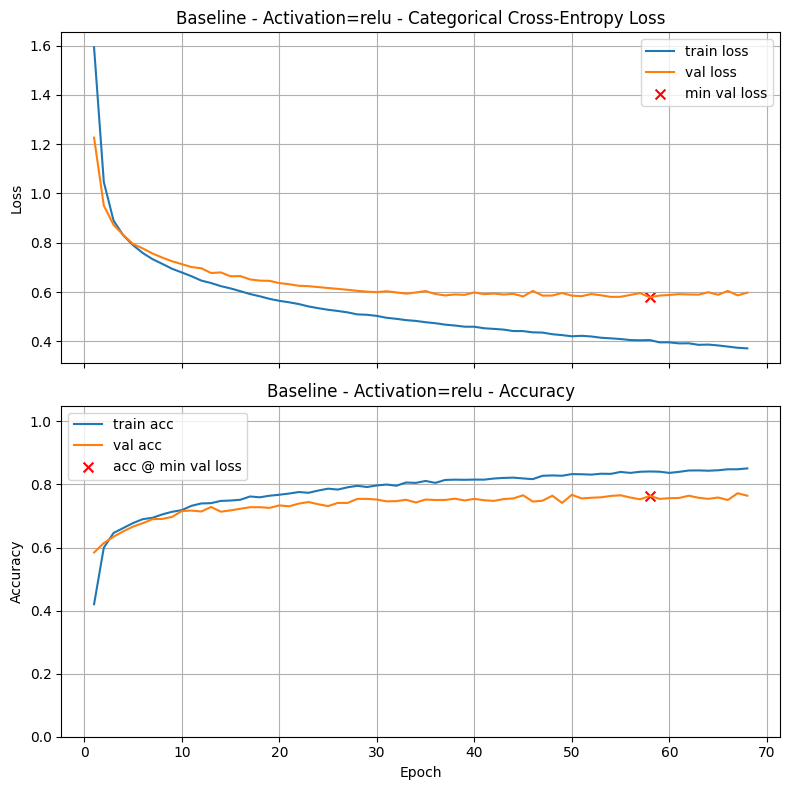

Final Training Loss:            0.3712
Final Training Accuracy:        0.8510
Final Validation Loss:          0.5973
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.5779 (Epoch 58)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.5911
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:06

Baseline - Activation=sigmoid



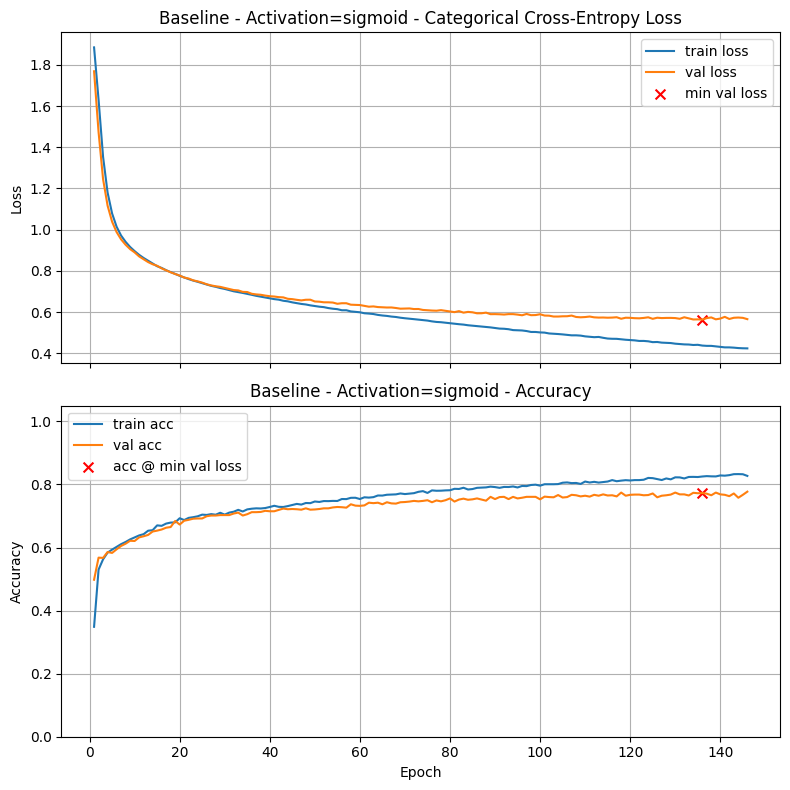

Final Training Loss:            0.4238
Final Training Accuracy:        0.8271
Final Validation Loss:          0.5656
Final Validation Accuracy:      0.7771
Minimum Validation Loss:        0.5636 (Epoch 136)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.5729
Test Accuracy: 0.7686

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:12

Baseline - Activation=tanh



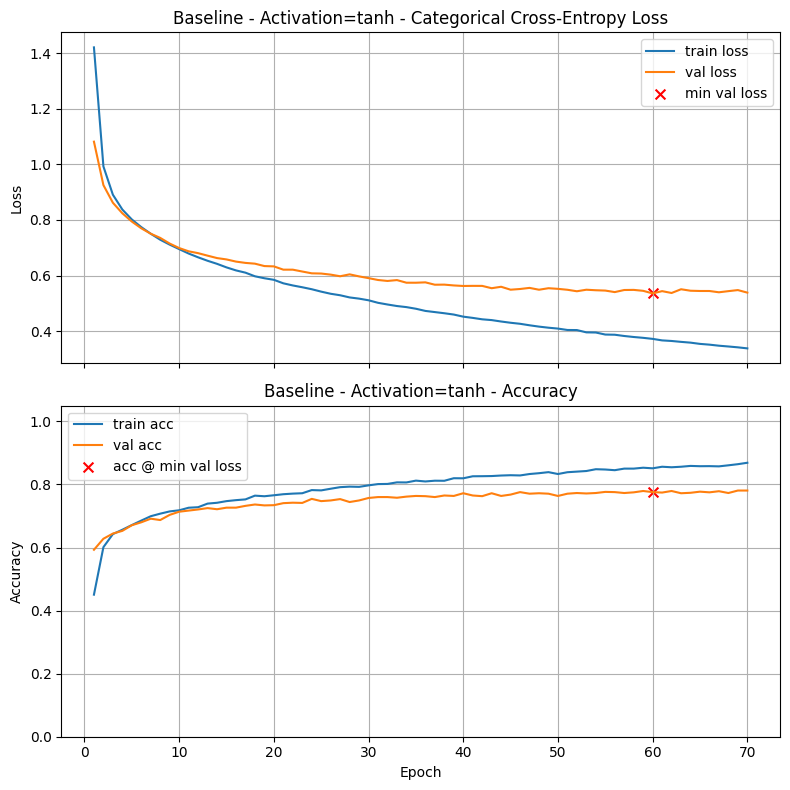

Final Training Loss:            0.3380
Final Training Accuracy:        0.8688
Final Validation Loss:          0.5386
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.5357 (Epoch 60)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.5708
Test Accuracy: 0.7607

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:06

=== Activation Function Results ===
Baseline - Activation=tanh              	0.7757
Baseline - Activation=sigmoid           	0.7729
Baseline - Activation=relu              	0.7636


In [12]:
# Your code here. Add as many cells as you need. 
activations = ["relu", "sigmoid", "tanh"]
histories = {}

for act in activations:
    model_baseline = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, act, 0.0, 0.0),   
            (32, act, 0.0, 0.0)    
        ],
        n_classes=n_classes
    )
    
    history = train_and_test(
        model_baseline,
        title=f"Baseline - Activation={act}"
    )
    histories[act] = history

print("\n=== Activation Function Results ===")
print_results()

### Graded Questions

In [13]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [14]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 2


In [15]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7757             # Replace 0.0 with your answer

In [16]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7757


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Baseline (tanh) - LR=0.001



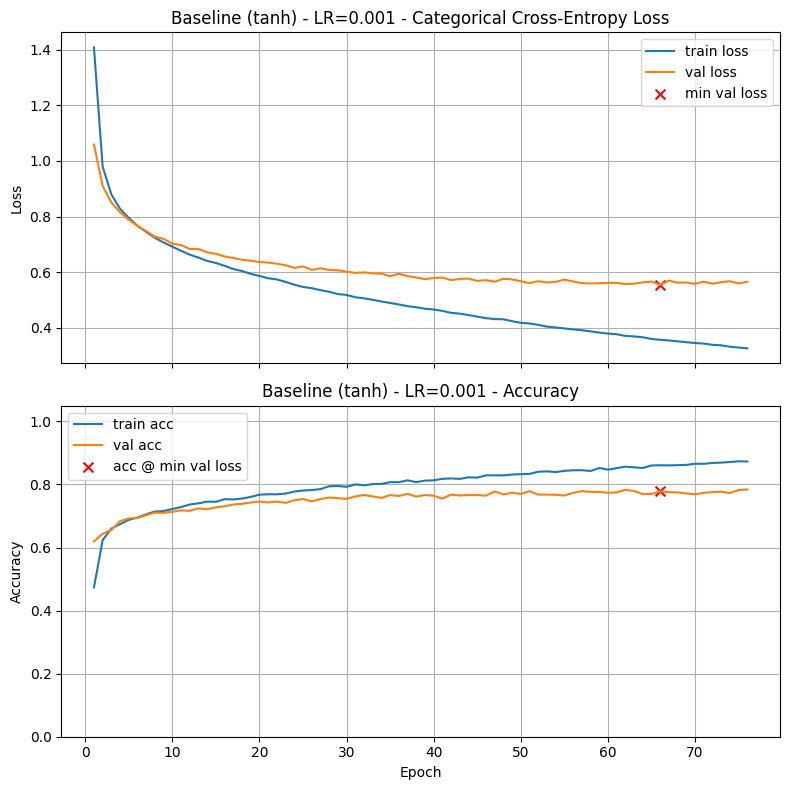

Final Training Loss:            0.3267
Final Training Accuracy:        0.8729
Final Validation Loss:          0.5659
Final Validation Accuracy:      0.7843
Minimum Validation Loss:        0.5545 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7779

Test Loss: 0.5521
Test Accuracy: 0.7879

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:06

Baseline (tanh) - LR=0.0005



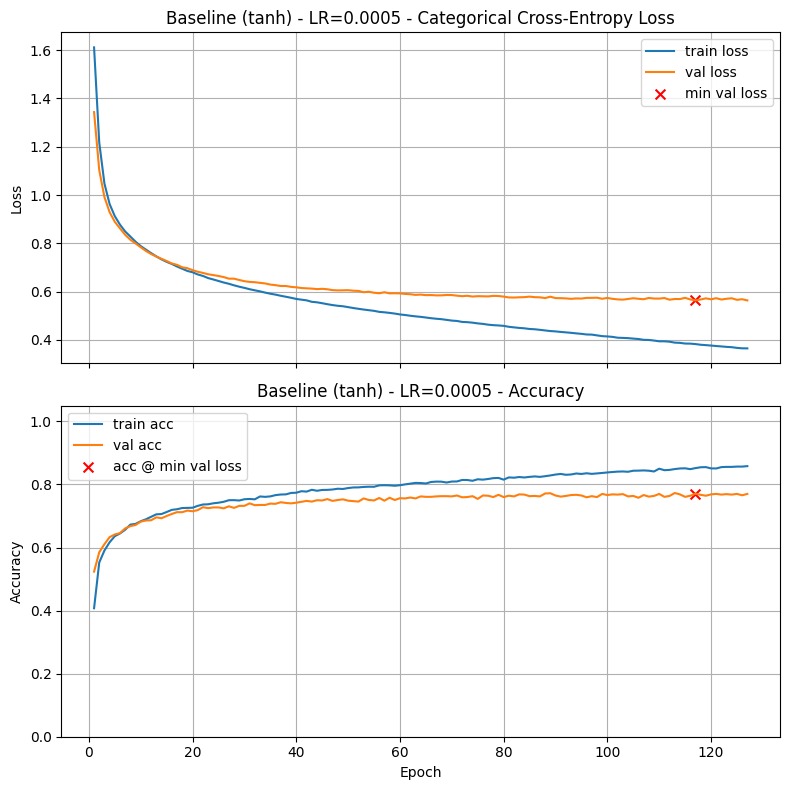

Final Training Loss:            0.3651
Final Training Accuracy:        0.8581
Final Validation Loss:          0.5637
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.5635 (Epoch 117)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.5725
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:11

Baseline (tanh) - LR=0.0001



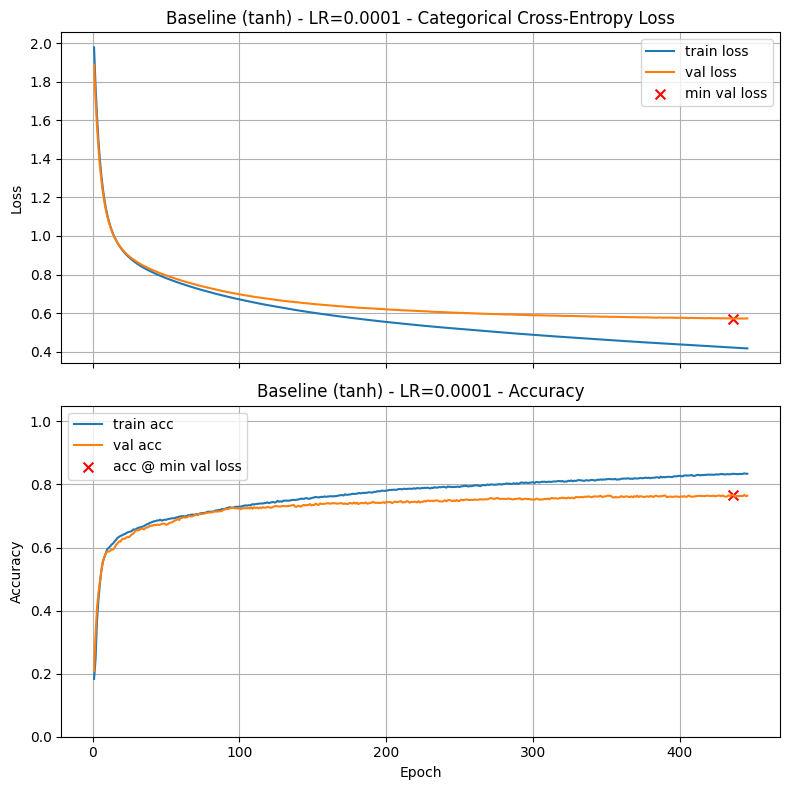

Final Training Loss:            0.4172
Final Training Accuracy:        0.8340
Final Validation Loss:          0.5722
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.5715 (Epoch 436)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.5914
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:33

Baseline (tanh) - LR=5e-05



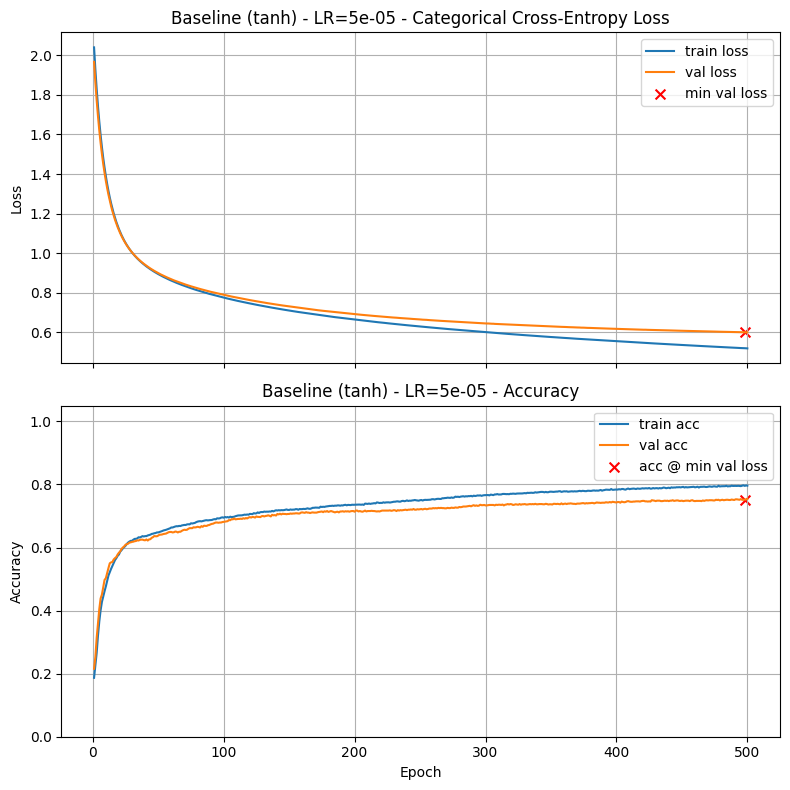

Final Training Loss:            0.5195
Final Training Accuracy:        0.7962
Final Validation Loss:          0.6005
Final Validation Accuracy:      0.7543
Minimum Validation Loss:        0.6005 (Epoch 498)
Validation Accuracy @ Min Loss: 0.7521

Test Loss: 0.6244
Test Accuracy: 0.7386

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:39

Baseline (tanh) - LR=1e-05



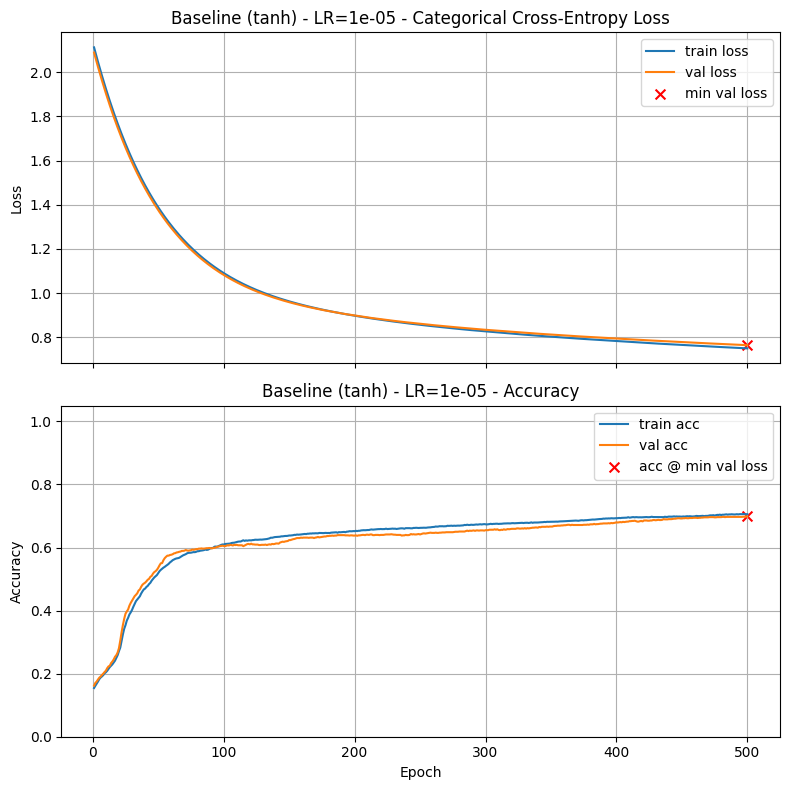

Final Training Loss:            0.7496
Final Training Accuracy:        0.7057
Final Validation Loss:          0.7641
Final Validation Accuracy:      0.6986
Minimum Validation Loss:        0.7641 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6986

Test Loss: 0.7743
Test Accuracy: 0.6964

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:00:41

=== Learning Rate Results ===
Baseline (tanh) - LR=0.001              	0.7779
Baseline - Activation=tanh              	0.7757
Baseline - Activation=sigmoid           	0.7729
Baseline (tanh) - LR=0.0005             	0.7707
Baseline (tanh) - LR=0.0001             	0.7664
Baseline - Activation=relu              	0.7636
Baseline (tanh) - LR=5e-05              	0.7521
Baseline (tanh) - LR=1e-05              	0.6986


In [17]:
# Your code here. Add as many cells as you need. 

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
histories_lr = {}

for lr in learning_rates:
    model_baseline = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, "tanh", 0.0, 0.0),  
            (32, "tanh", 0.0, 0.0)    
        ],
        n_classes=n_classes
    )
    
    history = train_and_test(
        model_baseline,
        lr_schedule=lr,
        epochs=500,
        title=f"Baseline (tanh) - LR={lr}"
    )
    histories_lr[lr] = history

print("\n=== Learning Rate Results ===")
print_results()

#### Graded Questions

In [18]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 0.001           # Replace 0.0 with your answer

In [19]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.001000


In [20]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7779             # Replace 0.0 with your answer

In [21]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7779


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Dropout d1=0.0, d2=0.3



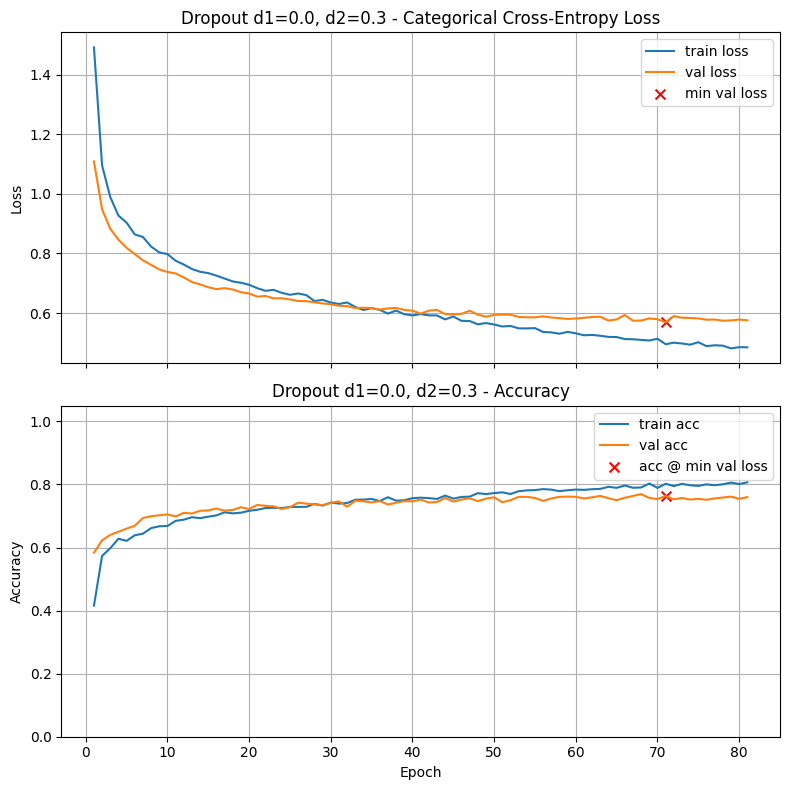

Final Training Loss:            0.4847
Final Training Accuracy:        0.8069
Final Validation Loss:          0.5755
Final Validation Accuracy:      0.7600
Minimum Validation Loss:        0.5687 (Epoch 71)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.5993
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:07

Dropout d1=0.0, d2=0.4



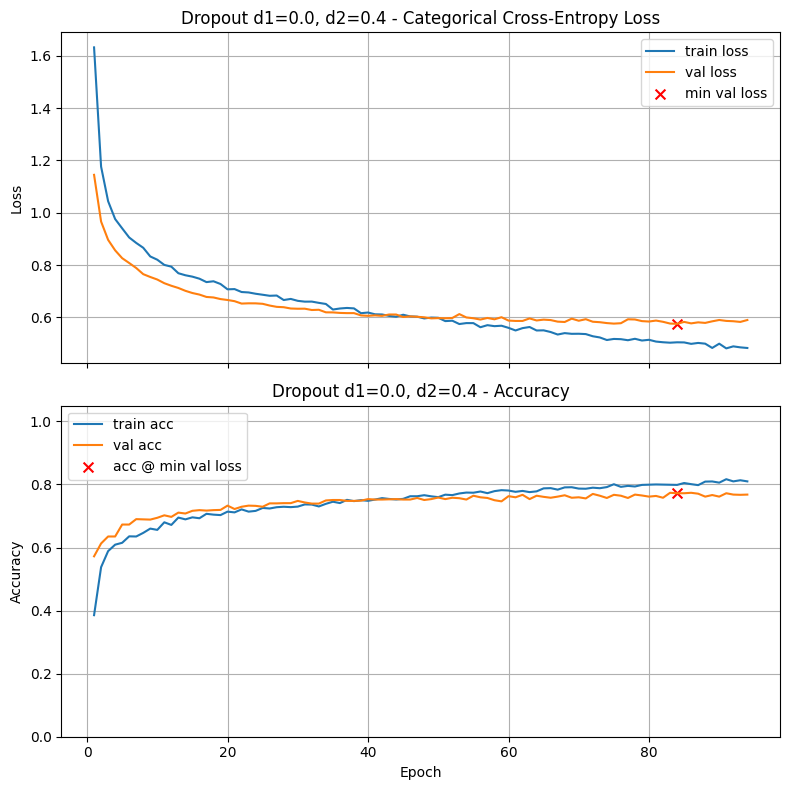

Final Training Loss:            0.4832
Final Training Accuracy:        0.8098
Final Validation Loss:          0.5901
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5755 (Epoch 84)
Validation Accuracy @ Min Loss: 0.7721

Test Loss: 0.6143
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:08

Dropout d1=0.0, d2=0.5



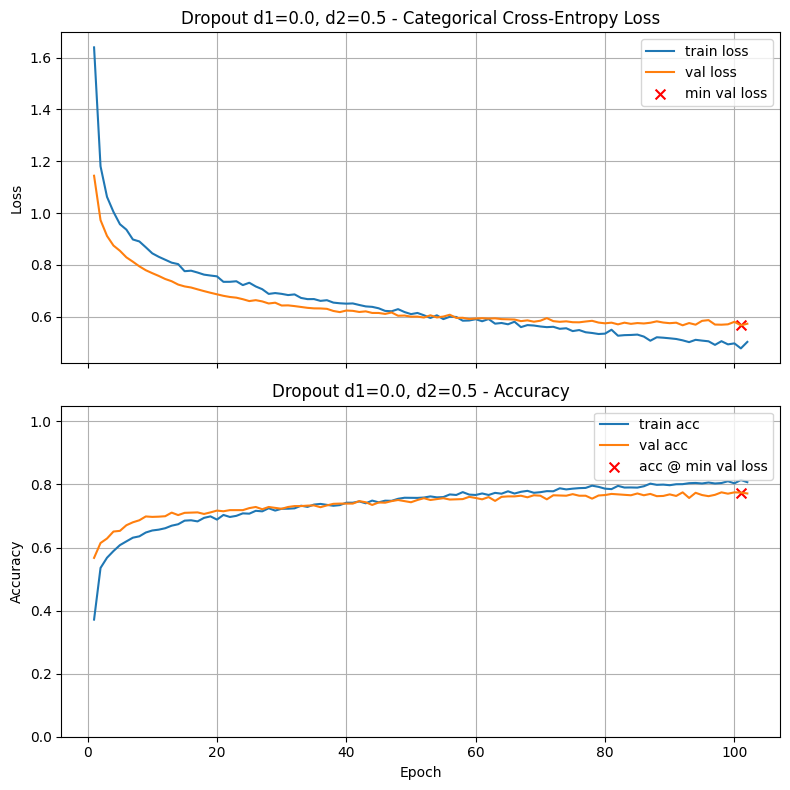

Final Training Loss:            0.5032
Final Training Accuracy:        0.8071
Final Validation Loss:          0.5733
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5672 (Epoch 101)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.6046
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:08

Dropout d1=0.1, d2=0.3



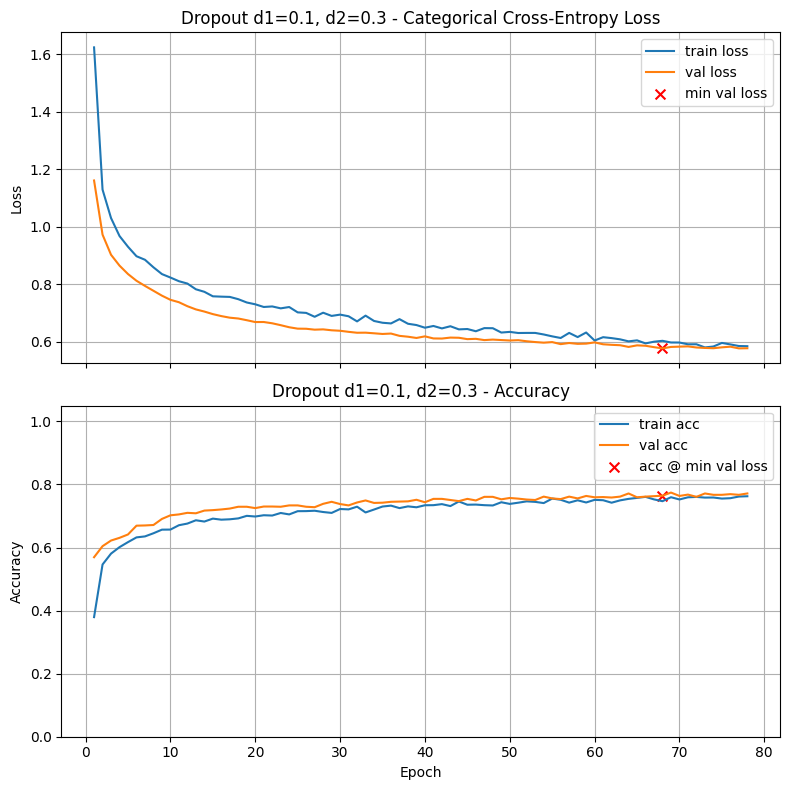

Final Training Loss:            0.5847
Final Training Accuracy:        0.7626
Final Validation Loss:          0.5776
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5771 (Epoch 68)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.6070
Test Accuracy: 0.7421

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:06

Dropout d1=0.1, d2=0.4



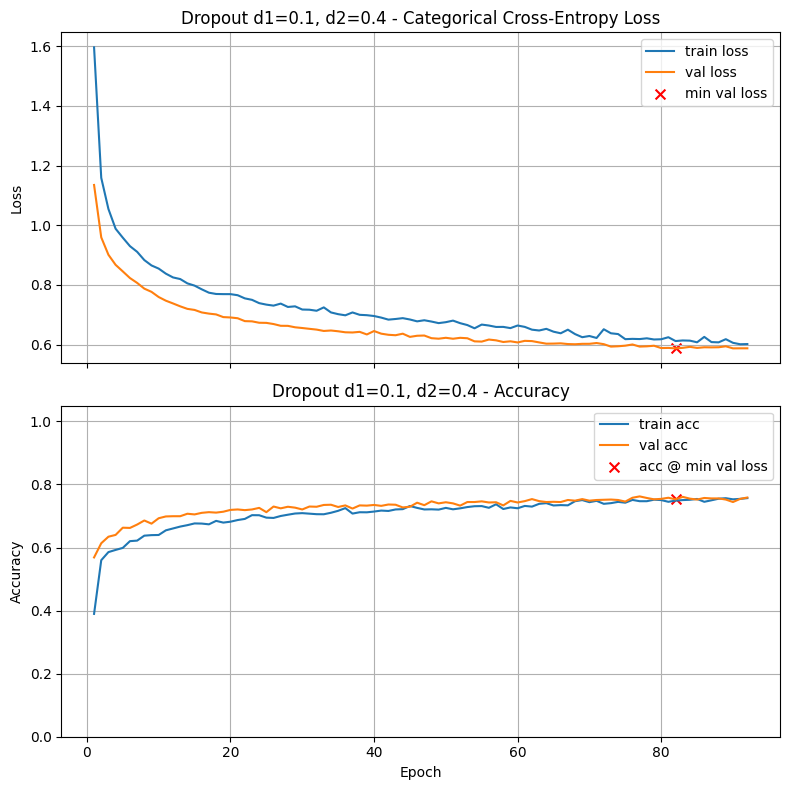

Final Training Loss:            0.6017
Final Training Accuracy:        0.7567
Final Validation Loss:          0.5875
Final Validation Accuracy:      0.7586
Minimum Validation Loss:        0.5872 (Epoch 82)
Validation Accuracy @ Min Loss: 0.7529

Test Loss: 0.6061
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:08

Dropout d1=0.1, d2=0.5



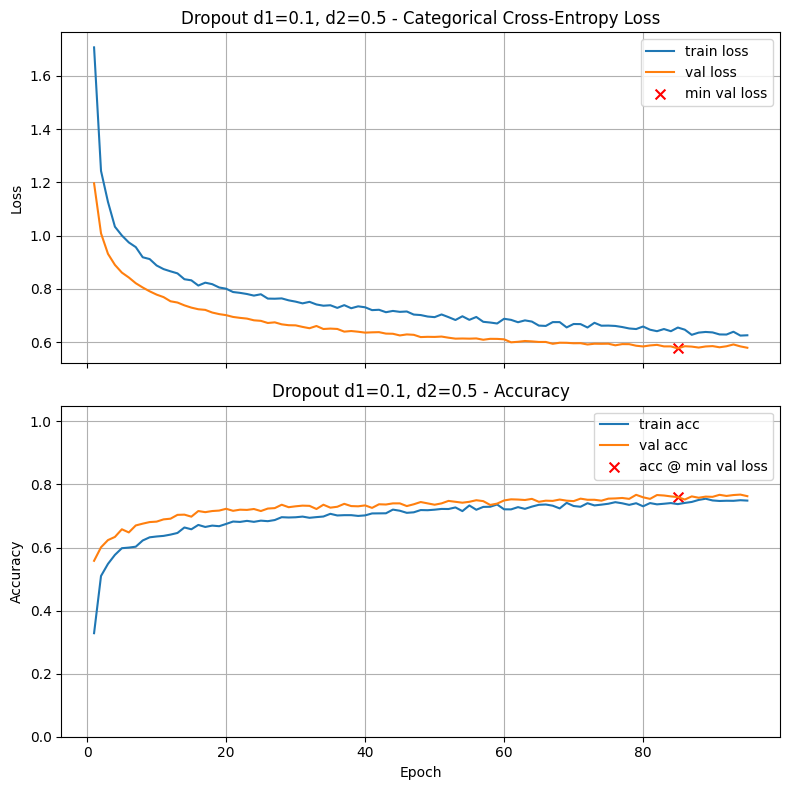

Final Training Loss:            0.6258
Final Training Accuracy:        0.7488
Final Validation Loss:          0.5790
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5766 (Epoch 85)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6153
Test Accuracy: 0.7421

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:08

Dropout d1=0.2, d2=0.3



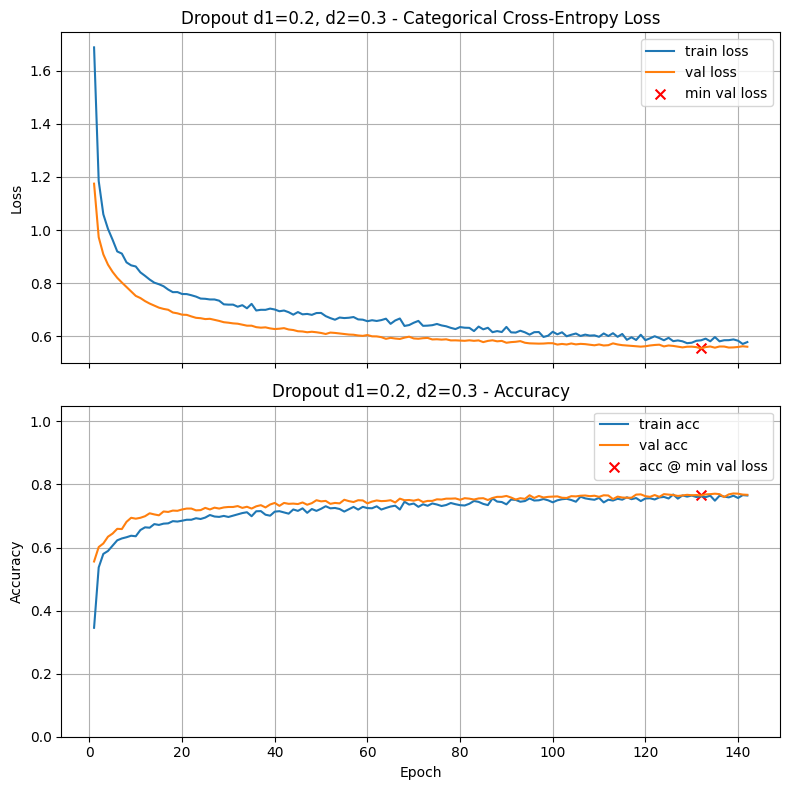

Final Training Loss:            0.5780
Final Training Accuracy:        0.7650
Final Validation Loss:          0.5605
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.5543 (Epoch 132)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.5816
Test Accuracy: 0.7664

Validation-Test Gap (accuracy): 0.001429

Execution Time: 00:00:12

Dropout d1=0.2, d2=0.4



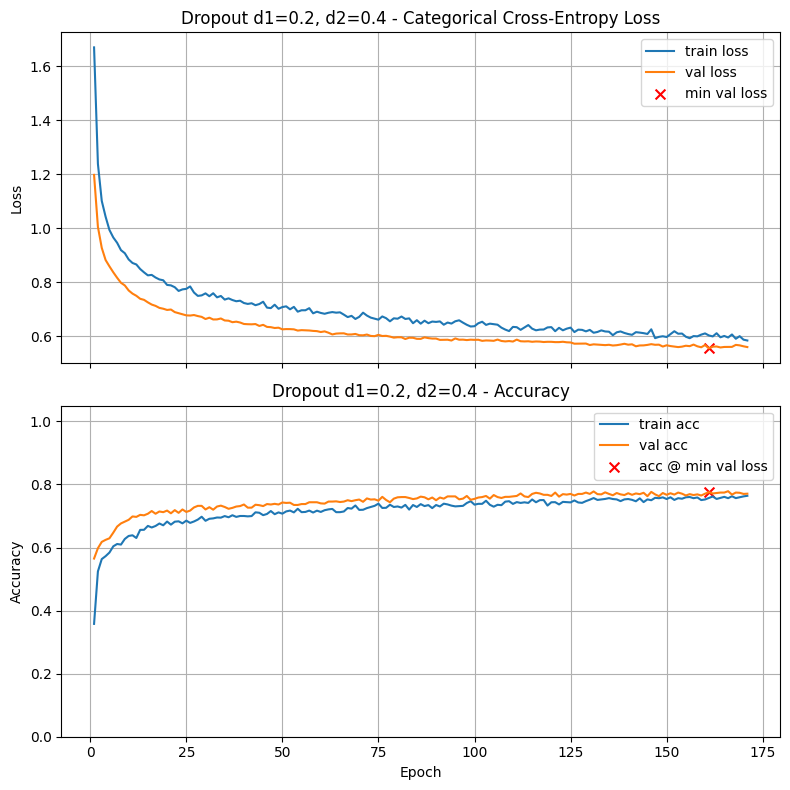

Final Training Loss:            0.5838
Final Training Accuracy:        0.7640
Final Validation Loss:          0.5594
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5545 (Epoch 161)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.5876
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:14

Dropout d1=0.2, d2=0.5



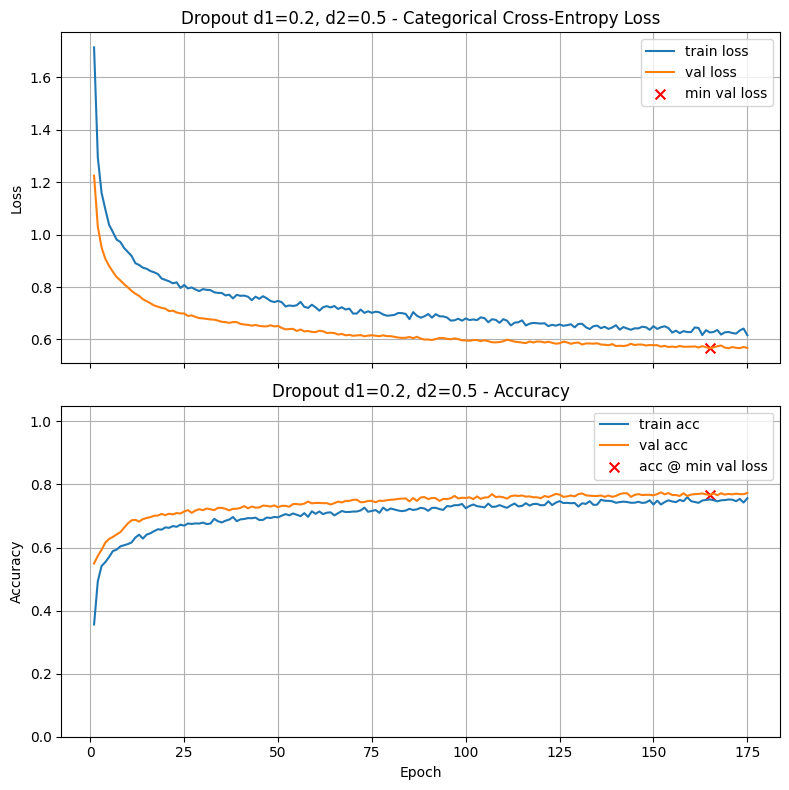

Final Training Loss:            0.6160
Final Training Accuracy:        0.7564
Final Validation Loss:          0.5673
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.5658 (Epoch 165)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6085
Test Accuracy: 0.7521

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:14

=== Dropout Results ===
Baseline (tanh) - LR=0.001              	0.7779
Baseline - Activation=tanh              	0.7757
Dropout d1=0.2, d2=0.4                  	0.7757
Dropout d1=0.0, d2=0.5                  	0.7743
Baseline - Activation=sigmoid           	0.7729
Dropout d1=0.0, d2=0.4                  	0.7721
Baseline (tanh) - LR=0.0005             	0.7707
Baseline (tanh) - LR=0.0001             	0.7664
Dropout d1=0.2, d2=0.5                  	0.7664
Dropout d1=0.2, d2=0.3                  	0.7650
Dropout d1=0.1, d2=0.3                  	0.7643
Baseline - Activation=relu              	0.7636
Dropout d1=0.0, d2=0.3                  	0.7

In [22]:
# Your code here. Add as many cells as you need. 
dropout_first = [0.0, 0.1, 0.2]
dropout_second = [0.3, 0.4, 0.5]

histories_dropout = {}

for d1 in dropout_first:
    for d2 in dropout_second:
        model_baseline = build_model(
            n_inputs=X_train.shape[1],
            layer_list=[
                (64, "tanh", 0.0, d1),   
                (32, "tanh", 0.0, d2)    
            ],
            n_classes=n_classes
        )
        
        history = train_and_test(
            model_baseline,
            lr_schedule=0.001,   
            epochs=500,
            title=f"Dropout d1={d1}, d2={d2}"
        )
        histories_dropout[(d1, d2)] = history

print("\n=== Dropout Results ===")
print_results()

In [23]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.2,0.4)             # Replace (0.0,0.0) with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.2, 0.4)


In [25]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.7757             # Replace 0.0 with your answer

In [26]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7757


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



L2 λ1=0.0001, λ2=0.0001



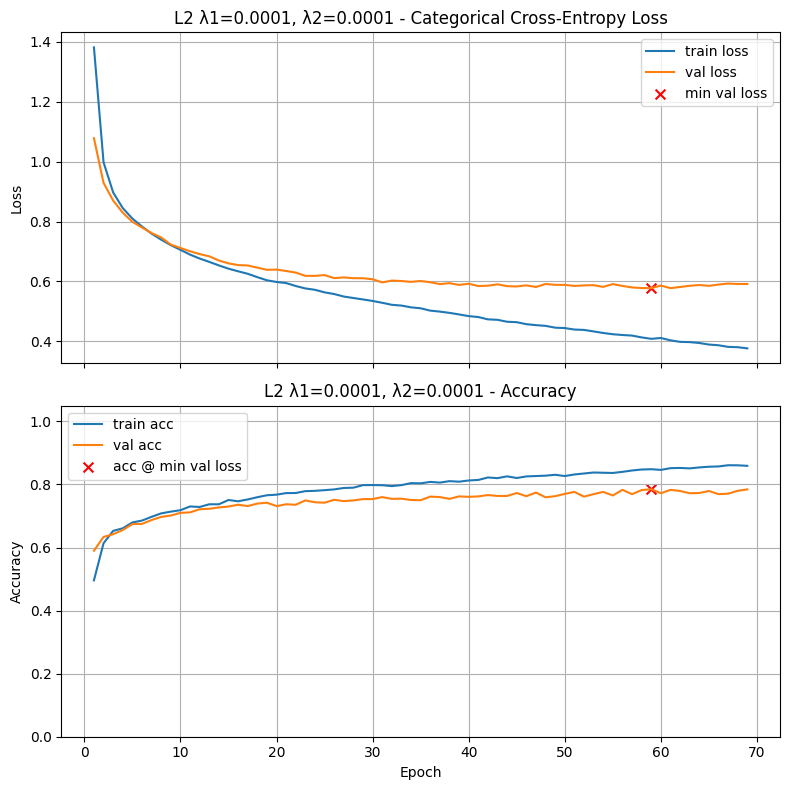

Final Training Loss:            0.3764
Final Training Accuracy:        0.8590
Final Validation Loss:          0.5915
Final Validation Accuracy:      0.7843
Minimum Validation Loss:        0.5775 (Epoch 59)
Validation Accuracy @ Min Loss: 0.7850

Test Loss: 0.5959
Test Accuracy: 0.7686

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:06

L2 λ1=0.001, λ2=0.001



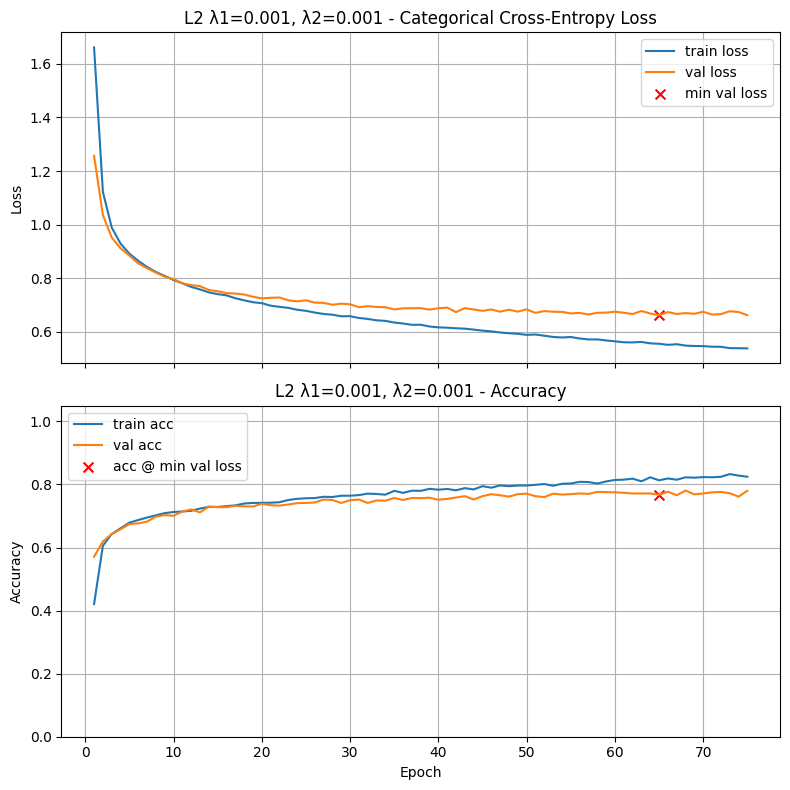

Final Training Loss:            0.5387
Final Training Accuracy:        0.8245
Final Validation Loss:          0.6626
Final Validation Accuracy:      0.7800
Minimum Validation Loss:        0.6623 (Epoch 65)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6799
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:06

L2 λ1=0.01, λ2=0.01



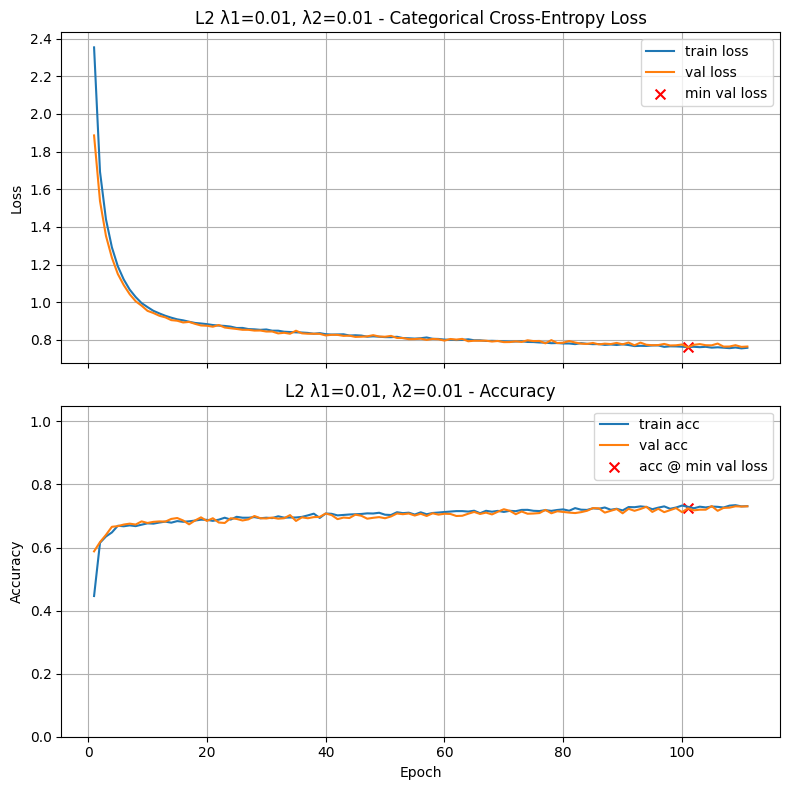

Final Training Loss:            0.7579
Final Training Accuracy:        0.7312
Final Validation Loss:          0.7647
Final Validation Accuracy:      0.7307
Minimum Validation Loss:        0.7603 (Epoch 101)
Validation Accuracy @ Min Loss: 0.7243

Test Loss: 0.7929
Test Accuracy: 0.7164

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:09

L2 λ1=0.0001, λ2=0.001



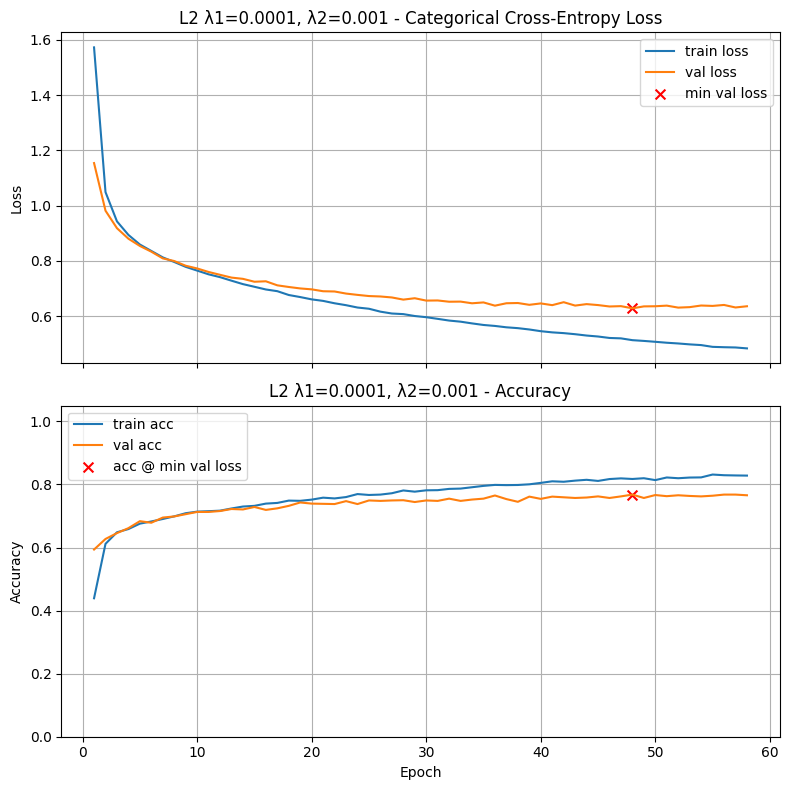

Final Training Loss:            0.4840
Final Training Accuracy:        0.8281
Final Validation Loss:          0.6364
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.6289 (Epoch 48)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.6485
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:00:05

L2 λ1=0.01, λ2=0.0001



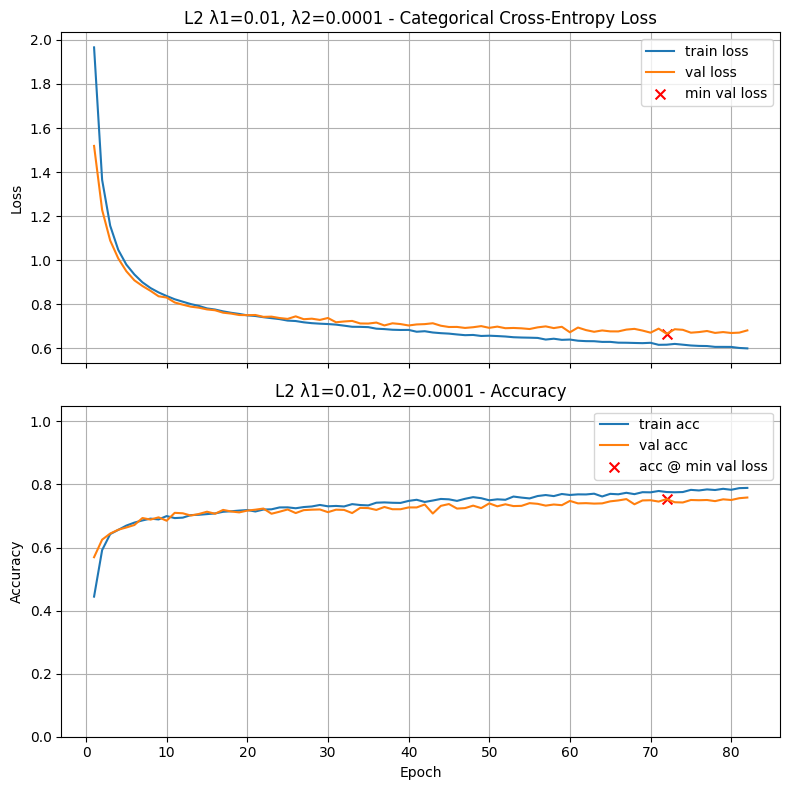

Final Training Loss:            0.5983
Final Training Accuracy:        0.7890
Final Validation Loss:          0.6801
Final Validation Accuracy:      0.7586
Minimum Validation Loss:        0.6647 (Epoch 72)
Validation Accuracy @ Min Loss: 0.7536

Test Loss: 0.6932
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:07

L2 λ1=0.001, λ2=0.0001



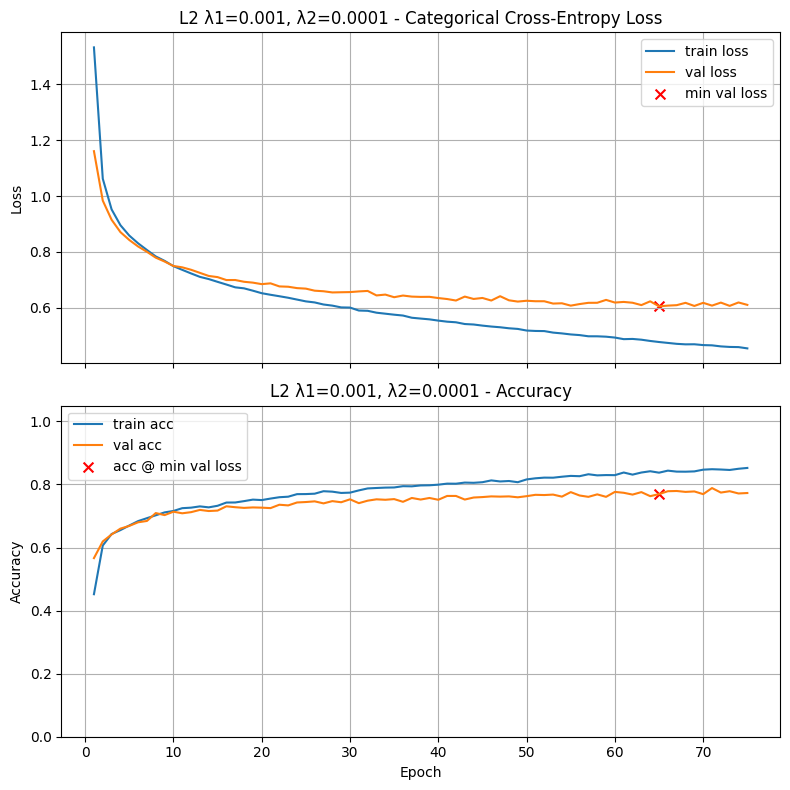

Final Training Loss:            0.4545
Final Training Accuracy:        0.8524
Final Validation Loss:          0.6103
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.6052 (Epoch 65)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6344
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:06

=== L2 Regularization Results ===
L2 λ1=0.0001, λ2=0.0001                 	0.7850
Baseline (tanh) - LR=0.001              	0.7779
Baseline - Activation=tanh              	0.7757
Dropout d1=0.2, d2=0.4                  	0.7757
Dropout d1=0.0, d2=0.5                  	0.7743
Baseline - Activation=sigmoid           	0.7729
Dropout d1=0.0, d2=0.4                  	0.7721
Baseline (tanh) - LR=0.0005             	0.7707
L2 λ1=0.001, λ2=0.0001                  	0.7693
L2 λ1=0.0001, λ2=0.001                  	0.7679
L2 λ1=0.001, λ2=0.001                   	0.7671
Baseline (tanh) - LR=0.0001             	0.7664
Dropout d1=0.2, d2=0.5             

In [27]:
# Your code here. Add as many cells as you need. 

l2_configs = [
    (1e-4, 1e-4),  
    (1e-3, 1e-3),
    (1e-2, 1e-2),
    (1e-4, 1e-3),
    (1e-2, 1e-4),
    (1e-3, 1e-4)   
]

histories_l2 = {}

for l2_1, l2_2 in l2_configs:
    model_baseline = build_model(
        n_inputs=X_train.shape[1],
        layer_list=[
            (64, "tanh", l2_1, 0.0),   
            (32, "tanh", l2_2, 0.0)    
        ],
        n_classes=n_classes
    )
    
    history = train_and_test(
        model_baseline,
        lr_schedule=0.001,
        epochs=500,
        title=f"L2 λ1={l2_1}, λ2={l2_2}"
    )
    histories_l2[(l2_1, l2_2)] = history

print("\n=== L2 Regularization Results ===")
print_results()

In [28]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (0.0001,0.0001)             # Replace (0.0,0.0) with your answer

In [29]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0001, 0.0001)


In [30]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7850             # Replace 0.0 with your answer

In [31]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7850


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Dropout=0.2, L2=0.0001



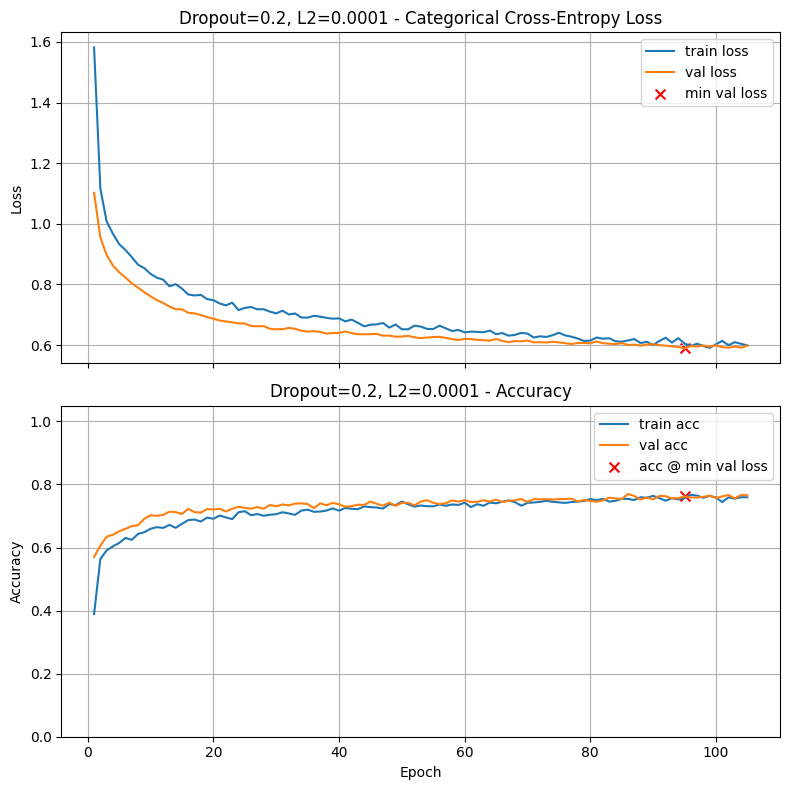

Final Training Loss:            0.5987
Final Training Accuracy:        0.7593
Final Validation Loss:          0.5981
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.5891 (Epoch 95)
Validation Accuracy @ Min Loss: 0.7621

Test Loss: 0.6183
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:10

Dropout=0.2, L2=0.001



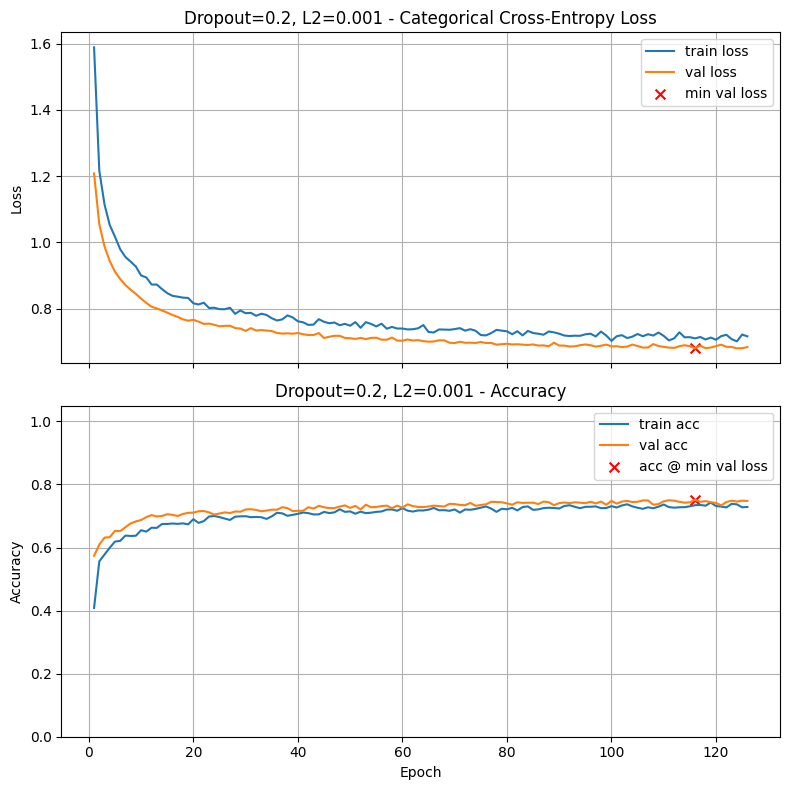

Final Training Loss:            0.7171
Final Training Accuracy:        0.7286
Final Validation Loss:          0.6845
Final Validation Accuracy:      0.7479
Minimum Validation Loss:        0.6807 (Epoch 116)
Validation Accuracy @ Min Loss: 0.7514

Test Loss: 0.7096
Test Accuracy: 0.7364

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:11

Dropout=0.2, L2=0.01



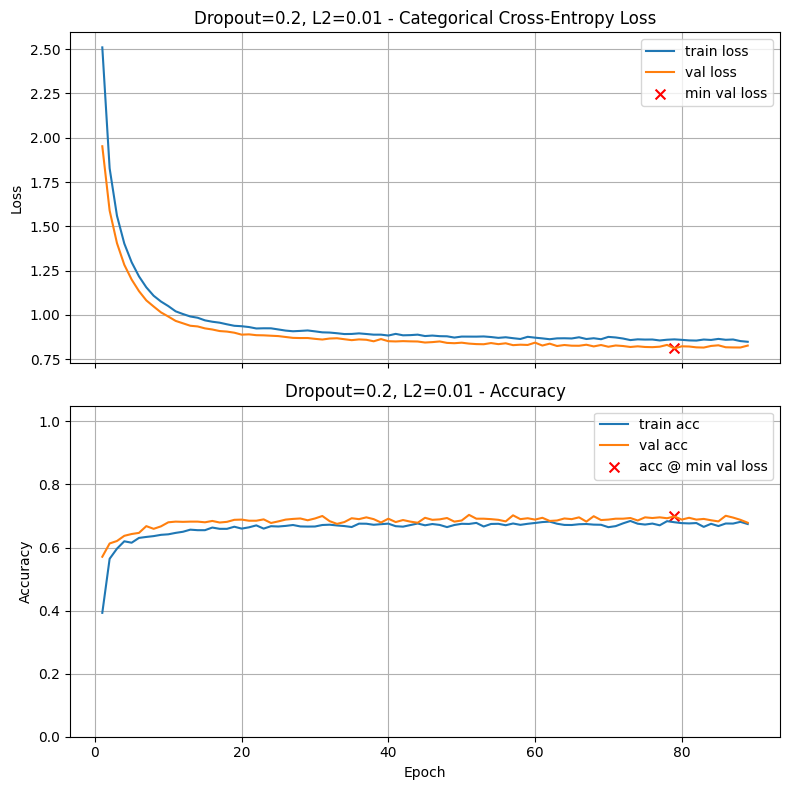

Final Training Loss:            0.8476
Final Training Accuracy:        0.6745
Final Validation Loss:          0.8263
Final Validation Accuracy:      0.6786
Minimum Validation Loss:        0.8104 (Epoch 79)
Validation Accuracy @ Min Loss: 0.6986

Test Loss: 0.8359
Test Accuracy: 0.6957

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:08

Dropout=0.4, L2=0.0001



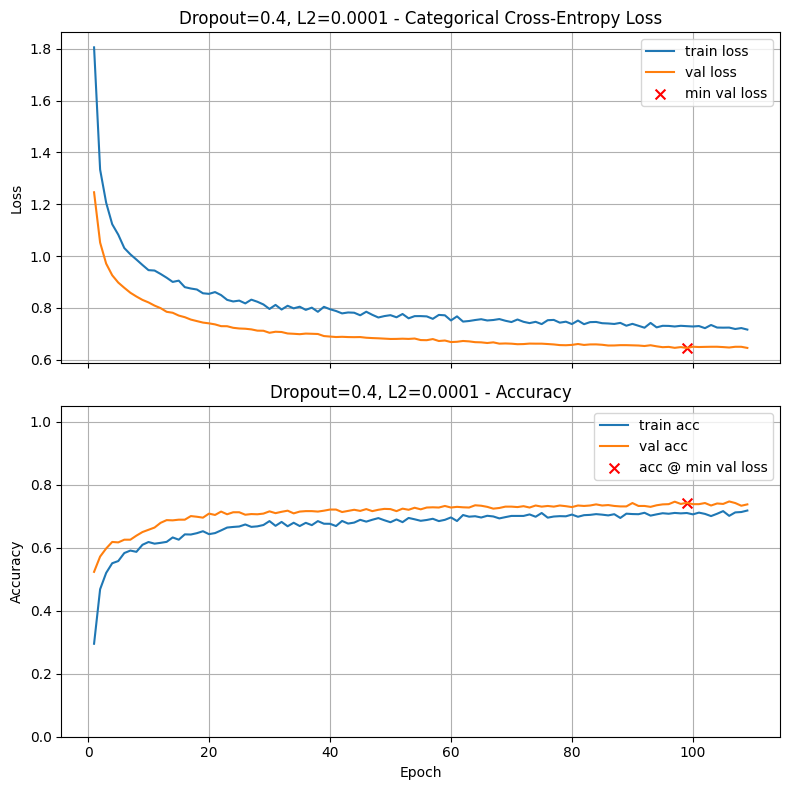

Final Training Loss:            0.7164
Final Training Accuracy:        0.7183
Final Validation Loss:          0.6457
Final Validation Accuracy:      0.7379
Minimum Validation Loss:        0.6457 (Epoch 99)
Validation Accuracy @ Min Loss: 0.7429

Test Loss: 0.6729
Test Accuracy: 0.7314

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:09

Dropout=0.4, L2=0.001



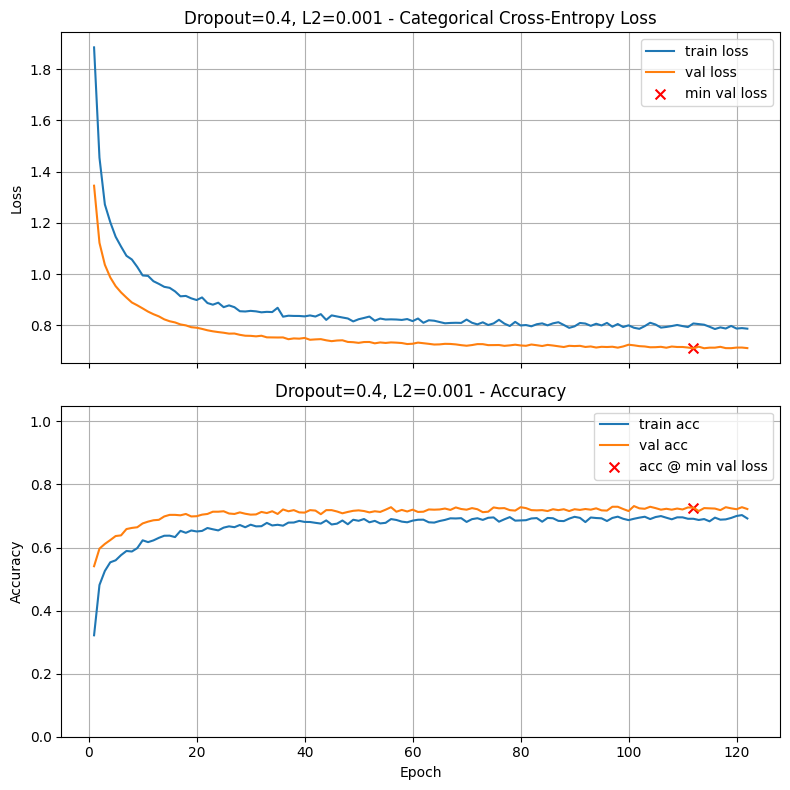

Final Training Loss:            0.7876
Final Training Accuracy:        0.6921
Final Validation Loss:          0.7118
Final Validation Accuracy:      0.7221
Minimum Validation Loss:        0.7108 (Epoch 112)
Validation Accuracy @ Min Loss: 0.7264

Test Loss: 0.7438
Test Accuracy: 0.7143

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:10

Dropout=0.4, L2=0.01



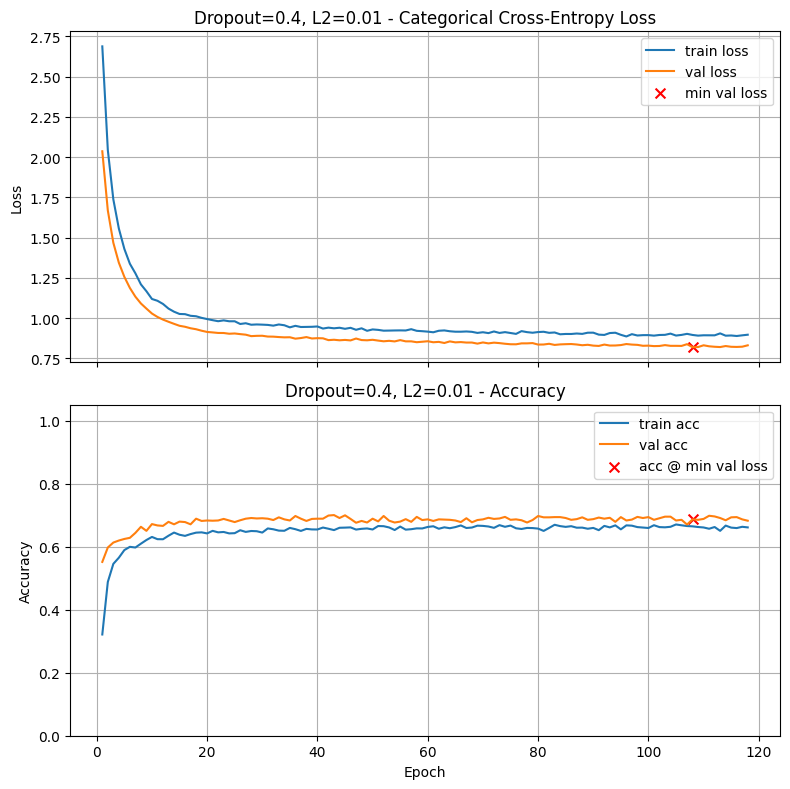

Final Training Loss:            0.8967
Final Training Accuracy:        0.6610
Final Validation Loss:          0.8308
Final Validation Accuracy:      0.6821
Minimum Validation Loss:        0.8189 (Epoch 108)
Validation Accuracy @ Min Loss: 0.6864

Test Loss: 0.8453
Test Accuracy: 0.6771

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:10

Reduced Dropout=0.1, L2=0.0001



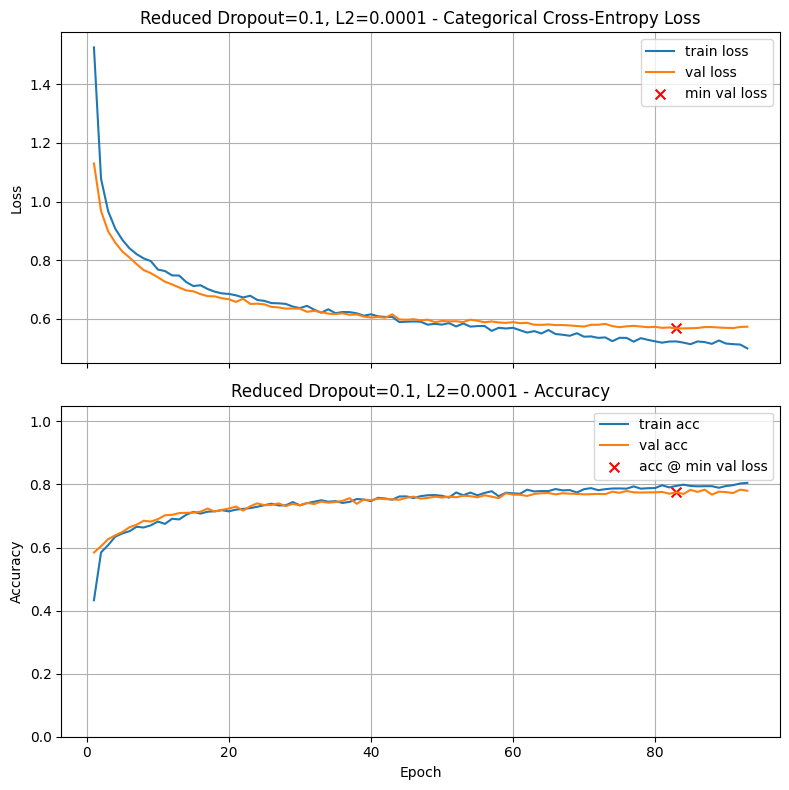

Final Training Loss:            0.4999
Final Training Accuracy:        0.8050
Final Validation Loss:          0.5737
Final Validation Accuracy:      0.7800
Minimum Validation Loss:        0.5677 (Epoch 83)
Validation Accuracy @ Min Loss: 0.7750

Test Loss: 0.5986
Test Accuracy: 0.7679

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:08

Reduced Dropout=0.1, L2=0.001



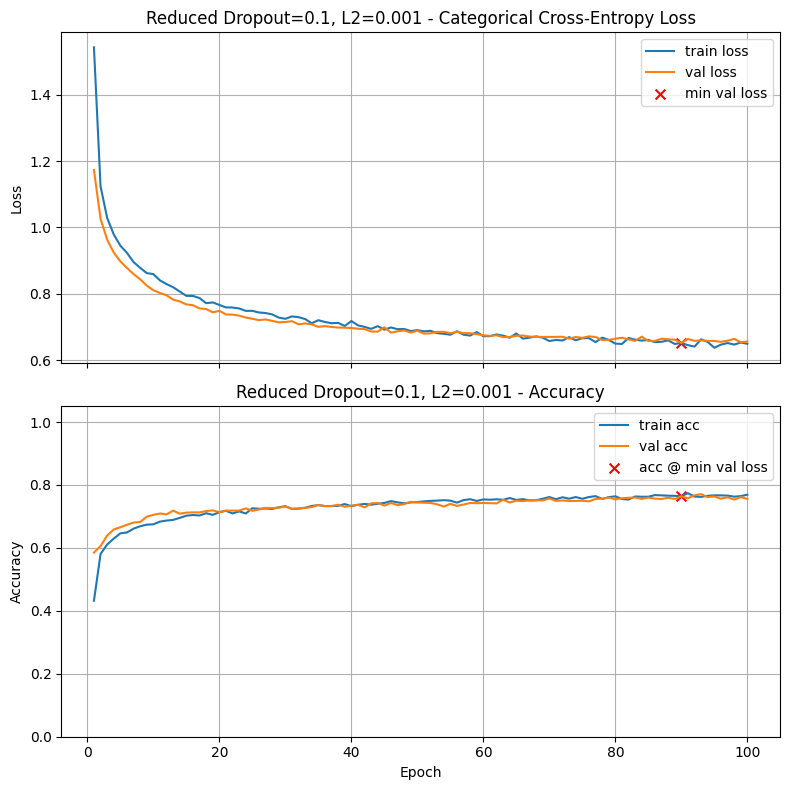

Final Training Loss:            0.6490
Final Training Accuracy:        0.7690
Final Validation Loss:          0.6558
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.6517 (Epoch 90)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.6917
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:09

Reduced Dropout=0.1, L2=0.01



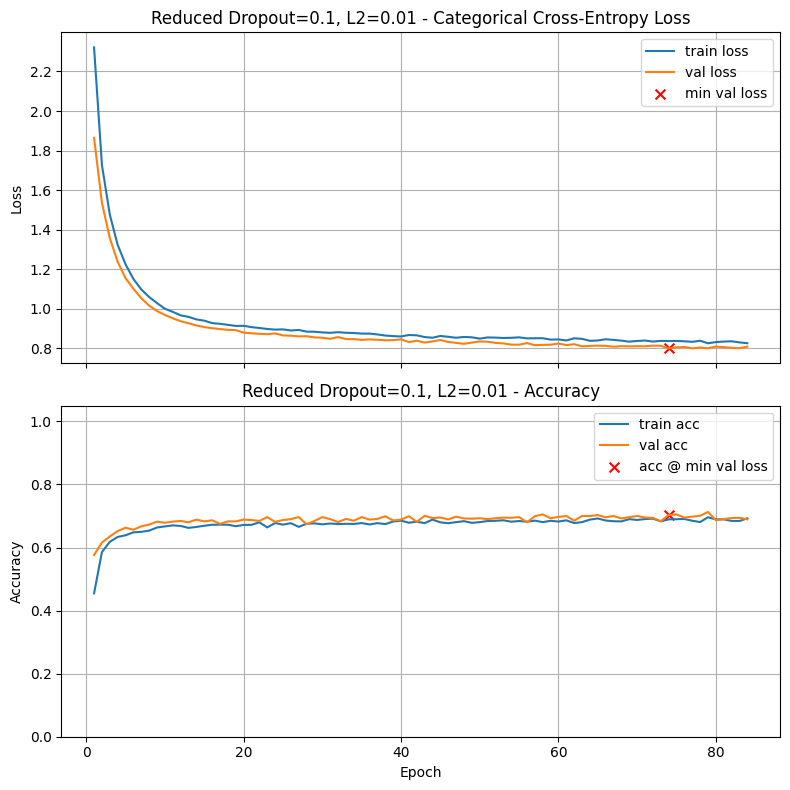

Final Training Loss:            0.8267
Final Training Accuracy:        0.6926
Final Validation Loss:          0.8092
Final Validation Accuracy:      0.6893
Minimum Validation Loss:        0.8005 (Epoch 74)
Validation Accuracy @ Min Loss: 0.7029

Test Loss: 0.8323
Test Accuracy: 0.7021

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:08

Reduced Dropout=0.3, L2=0.0001



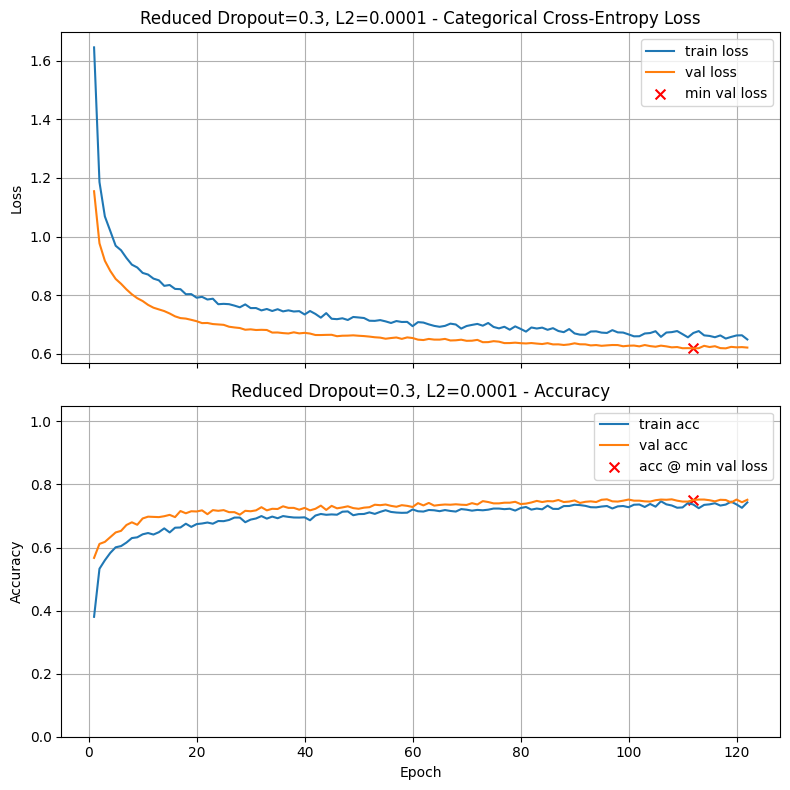

Final Training Loss:            0.6491
Final Training Accuracy:        0.7431
Final Validation Loss:          0.6214
Final Validation Accuracy:      0.7514
Minimum Validation Loss:        0.6186 (Epoch 112)
Validation Accuracy @ Min Loss: 0.7507

Test Loss: 0.6468
Test Accuracy: 0.7414

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:11

Reduced Dropout=0.3, L2=0.001



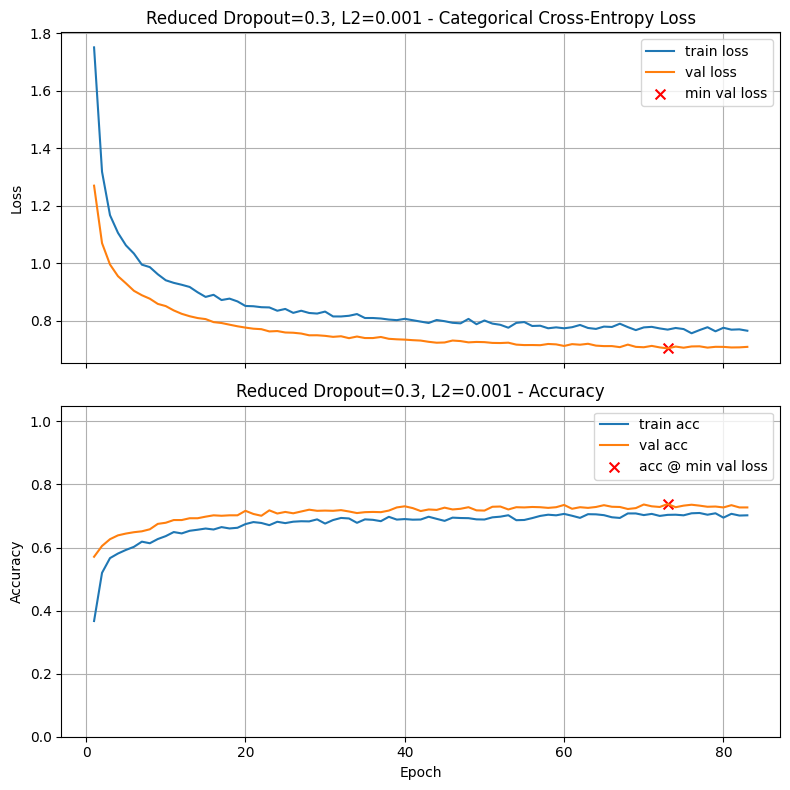

Final Training Loss:            0.7657
Final Training Accuracy:        0.7021
Final Validation Loss:          0.7096
Final Validation Accuracy:      0.7271
Minimum Validation Loss:        0.7043 (Epoch 73)
Validation Accuracy @ Min Loss: 0.7379

Test Loss: 0.7370
Test Accuracy: 0.7200

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:07

Reduced Dropout=0.3, L2=0.01



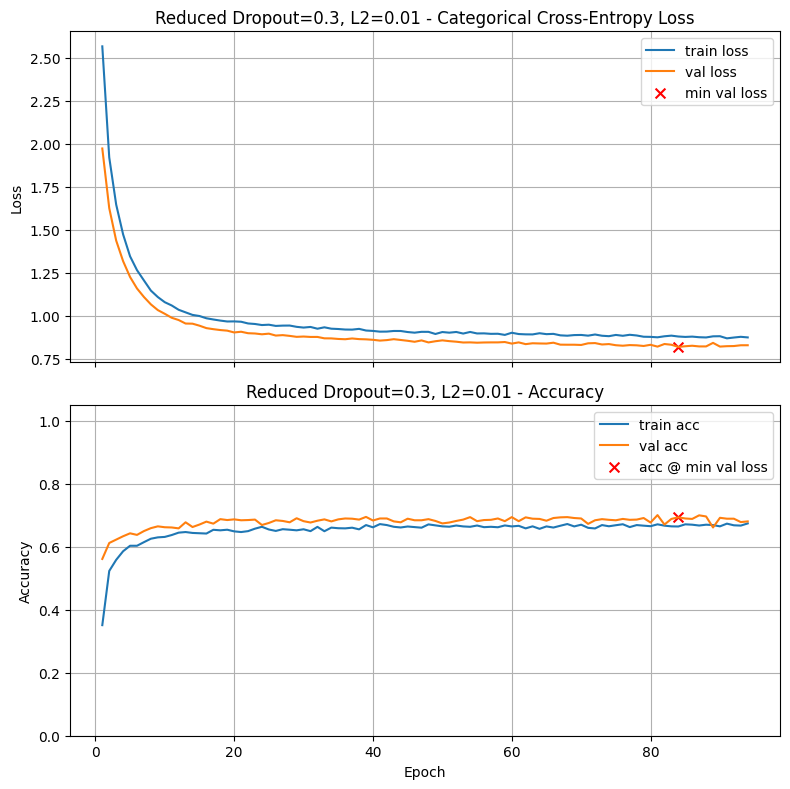

Final Training Loss:            0.8744
Final Training Accuracy:        0.6743
Final Validation Loss:          0.8289
Final Validation Accuracy:      0.6807
Minimum Validation Loss:        0.8192 (Epoch 84)
Validation Accuracy @ Min Loss: 0.6936

Test Loss: 0.8430
Test Accuracy: 0.6929

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:08

=== Dropout + L2 Results ===
L2 λ1=0.0001, λ2=0.0001                 	0.7850
Baseline (tanh) - LR=0.001              	0.7779
Baseline - Activation=tanh              	0.7757
Dropout d1=0.2, d2=0.4                  	0.7757
Reduced Dropout=0.1, L2=0.0001          	0.7750
Dropout d1=0.0, d2=0.5                  	0.7743
Baseline - Activation=sigmoid           	0.7729
Dropout d1=0.0, d2=0.4                  	0.7721
Baseline (tanh) - LR=0.0005             	0.7707
L2 λ1=0.001, λ2=0.0001                  	0.7693
L2 λ1=0.0001, λ2=0.001                  	0.7679
L2 λ1=0.001, λ2=0.001                   	0.7671
Baseline (tanh) - LR=0.0001             

In [32]:
# Your code here. Add as many cells as you need.

dropout_rates = [0.2, 0.4]       
reduced_dropout = [0.1, 0.3]      
l2_values = [1e-4, 1e-3, 1e-2]

# Baseline with dropout rates from Problem Three
histories_drl2 = {}
for dr in dropout_rates:
    for l2 in l2_values:
        model_baseline = build_model(
            n_inputs=X_train.shape[1],
            layer_list=[
                (64, "tanh", l2, dr),
                (32, "tanh", l2, dr)
            ],
            n_classes=n_classes
        )
        
        history = train_and_test(
            model_baseline,
            lr_schedule=0.001,
            epochs=500,
            title=f"Dropout={dr}, L2={l2}"
        )
        histories_drl2[(dr, l2)] = history

# Reduced dropout rates
for dr in reduced_dropout:
    for l2 in l2_values:
        model_baseline = build_model(
            n_inputs=X_train.shape[1],
            layer_list=[
                (64, "tanh", l2, dr),
                (32, "tanh", l2, dr)
            ],
            n_classes=n_classes
        )
        
        history = train_and_test(
            model_baseline,
            lr_schedule=0.001,
            epochs=500,
            title=f"Reduced Dropout={dr}, L2={l2}"
        )
        histories_drl2[(dr, l2)] = history

print("\n=== Dropout + L2 Results ===")
print_results()

In [33]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7750             # Replace 0.0 with your answer

In [34]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7750


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Best Model - ExpDecay (tanh, L2)



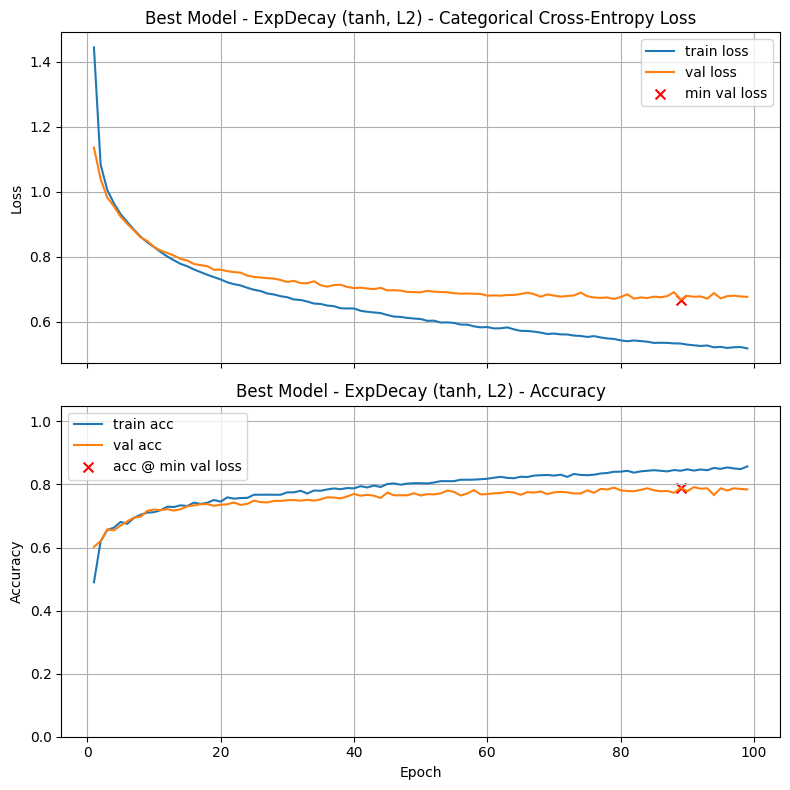

Final Training Loss:            0.5177
Final Training Accuracy:        0.8571
Final Validation Loss:          0.6764
Final Validation Accuracy:      0.7843
Minimum Validation Loss:        0.6680 (Epoch 89)
Validation Accuracy @ Min Loss: 0.7893

Test Loss: 0.6879
Test Accuracy: 0.7650

Validation-Test Gap (accuracy): 0.024286

Execution Time: 00:00:07

=== Final Best Model Results ===
Best Model - ExpDecay (tanh, L2)        	0.7893
L2 λ1=0.0001, λ2=0.0001                 	0.7850
Baseline (tanh) - LR=0.001              	0.7779
Baseline - Activation=tanh              	0.7757
Dropout d1=0.2, d2=0.4                  	0.7757
Reduced Dropout=0.1, L2=0.0001          	0.7750
Dropout d1=0.0, d2=0.5                  	0.7743
Baseline - Activation=sigmoid           	0.7729
Dropout d1=0.0, d2=0.4                  	0.7721
Baseline (tanh) - LR=0.0005             	0.7707
L2 λ1=0.001, λ2=0.0001                  	0.7693
L2 λ1=0.0001, λ2=0.001                  	0.7679
L2 λ1=0.001, λ2=0.001               

In [35]:
# Your code here
hidden_layers = [
    (128, "tanh", 1e-3, 0),   # widened layers, same L2, no dropout
    (64,  "tanh", 1e-3, 0)    
]

batch_size = 128   # larger batch size for stability
initial_lr = 0.001
decay_steps = 1000   
decay_rate = 0.95    

lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False  
)

model_best = build_model(
    n_inputs=X_train.shape[1],
    layer_list=hidden_layers,
    n_classes=n_classes
)

history_best = train_and_test(
    model_best,
    lr_schedule=lr_schedule,
    batch_size=batch_size,
    epochs=500,
    title="Best Model - ExpDecay (tanh, L2)"
)

print("\n=== Final Best Model Results ===")
print_results()

In [36]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7893             # Replace 0.0 with your answer

In [37]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7893


### Optional: Print out your results of all experiments

In [38]:
print_results()

Best Model - ExpDecay (tanh, L2)        	0.7893
L2 λ1=0.0001, λ2=0.0001                 	0.7850
Baseline (tanh) - LR=0.001              	0.7779
Baseline - Activation=tanh              	0.7757
Dropout d1=0.2, d2=0.4                  	0.7757
Reduced Dropout=0.1, L2=0.0001          	0.7750
Dropout d1=0.0, d2=0.5                  	0.7743
Baseline - Activation=sigmoid           	0.7729
Dropout d1=0.0, d2=0.4                  	0.7721
Baseline (tanh) - LR=0.0005             	0.7707
L2 λ1=0.001, λ2=0.0001                  	0.7693
L2 λ1=0.0001, λ2=0.001                  	0.7679
L2 λ1=0.001, λ2=0.001                   	0.7671
Baseline (tanh) - LR=0.0001             	0.7664
Dropout d1=0.2, d2=0.5                  	0.7664
Dropout d1=0.2, d2=0.3                  	0.7650
Dropout d1=0.1, d2=0.3                  	0.7643
Baseline - Activation=relu              	0.7636
Dropout d1=0.0, d2=0.3                  	0.7636
Reduced Dropout=0.1, L2=0.001           	0.7636
Dropout=0.2, L2=0.0001                  

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?